## Regression of a function with a neural network in 1D

### Exercise 2:
Modify the code to solve the differential equation
$$
\frac{dy}{dx} = -y(x);\; y(0) = 1
$$
using
 a) finite difference method to calculate derivatives.
 b) automatic differentiation to calculate derivatives. 
Add boundary conditions as another loss function.

### Exercise 3:
Solve the same differential equation using
$$
y = 1+x\,\mathrm{Net}(x)
$$
This way we do not need to add another loss function.

### Exercise 4:
Solve the differential equation
$$
\frac{dy}{dx} = -y\,(x-1);\; y(0) = 1
$$
Run the code twice to see whether the results are the same. The results for two successive runs may not be the same. Explain why this is the case.

0   36.956947326660156
10   0.528872013092041
20   0.20476429164409637
30   0.007854641415178776
40   0.0012090076925233006
50   6.250101615702674e+24
60   3.6211985731401874e+27
70   nan
80   nan
90   nan
Final loss: nan


c:\Users\jakob\miniconda3\envs\torchenv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([100, 1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


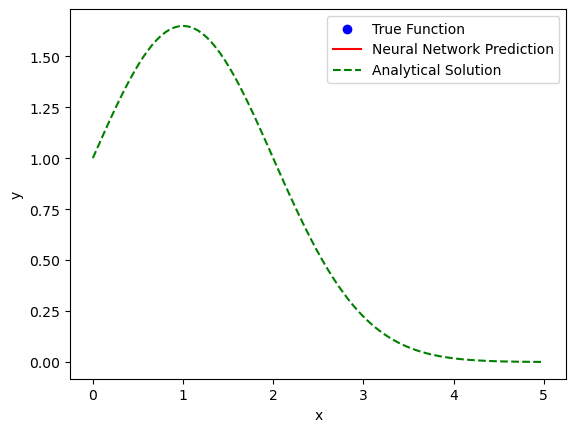

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt



# Generate synthetic data
x = torch.linspace(0, 5, 100)
x.requires_grad = True
x = x.unsqueeze(-1)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        # self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        # x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the neural network
net = Net()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.LBFGS(net.parameters(), lr=0.01)




def getout(x, net):
    return 1 + x * net(x)
    # return net(x)

def true_function(x, net):
    h = 0.001
    dydx = (getout(x+h, net) - getout(x, net)) / h

    # if x.grad is None:
    #     dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    # else:
    #     dydx = x.grad
    
    return -dydx

def true_function2(x, net):
    h = 0.001
    dydx = (getout(x+h, net) - getout(x, net)) / h
    return -dydx/(x-1)


diff_eq = true_function2

analytical = np.exp(-x) if (diff_eq == true_function) else lambda x: np.exp(x-x*x/2)

# Training loop
for i in range(100):
    def closure():
        optimizer.zero_grad()
        # outputs = net(x)
        outputs = getout(x, net)
        y = diff_eq(x, net)
        loss = criterion(outputs, y) #+ torch.square(net(torch.tensor([0.])) - torch.tensor( [1.]))/10.
        loss.backward(retain_graph=True)
        return loss

    loss=optimizer.step(closure)

    if(i%10==0):
      print(i," ",loss.item())
# Print the final loss
      
y = diff_eq(x, net).detach()

with torch.no_grad():
    outputs = getout(x, net)
    loss = criterion(outputs, y.unsqueeze(-1))

print(f'Final loss: {loss.item()}')

x = x.detach().numpy()
# Plot the results
plt.scatter(x, y.detach().numpy(), label='True Function', color='blue')
plt.plot(x,  outputs.detach().numpy(), label='Neural Network Prediction', color='red')
plt.plot(x, analytical(x), '--', label='Analytical Solution', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()